# Level-set method
***

## Introduction
The level-set method is a method designed for modeling material interaction. The main idea is based on a function $l$, which satisfies the following.

$$ l(x) \begin{cases}
         > 0 \text{ if } x \in \Omega_1 \\
         < 0 \text{ in } x \in \Omega_2
    \end{cases}. $$

We will focus only on the interaction between two incompressible Navier-Stokes equations with different
constant parameters $\rho_i, \mu_i \in \Omega_i$ for $i  \in  \{ 1, 2 \}$. The function $l$ allows us to define
viscosity $\mu$ and density $\rho$ in the whole domain $\Omega$ as a single
function
\begin{equation*}
    \mu(l) = \frac{1}{2}(\text{sign}(l) + 1)\mu_1 + \frac{1}{2}(\text{sign}(l) - 1) \mu_2
\end{equation*}
and
\begin{equation*}
    \rho(l) = \frac{1}{2}(\text{sign}(l) + 1)\rho_1 + \frac{1}{2}(\text{sign}(l) - 1) \rho_2.
\end{equation*}
Because we would like to solve the evolution problem, the $\Omega_i$ and the function $l$
have to depend on time. We want $l$ to be constant along streamlines for the prescribed velocity field $v$.
This condition is satisfied if
$$ \partial_t l(x, t) + \text{div}(l(x, t) v(x,  t)) = 0. $$
We can now formulate the whole system, firstly in the strong sense.
$$ \rho(l) \left( \partial_t v + (v \cdot \nabla) v \right)  = \text{div}\left(\mathbb{T}(\mu(l), \nabla v)\right) + \rho(l)g,$$

$$ \mathbb{T}(\mu(l), \nabla v) = \mu(l)\left( \nabla v + (\nabla v)^T \right) - p\mathbb{I}, $$

$$ \partial_t l + \text{div}(l v) = 0, $$

$$ \text{div}(v) = 0. $$

## Rayleigh-Taylor Example
Let us assume a rectangular domain with two fluids as it is desctibed in the figure below. We will cosidere Navier-Stokes fluid for both of them.
The fluids will stick on the boundary of the domain, so $v = 0$ at $\partial \Omega$.
<div align=center>
<img src="pics/rt.png" width="200"/>
</div>

## Implementation

In [461]:
import dolfin as df
import matplotlib.pyplot as plt

Then we define the mesh.

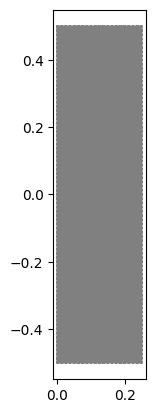

In [462]:
mesh_corse = df.RectangleMesh(
        df.Point(0.0, -0.5), df.Point(0.25, 0.5), 20, 80, 'crossed'
)
df.plot(mesh_corse)
plt.show()

We define the initial conditions for velocity and levelset. 

In [463]:
class InitialConditionSigmoid(df.UserExpression):

    def __init__(self, **kwargs):
        self.center = [0.125, 0.35]
        self.radius = df.sqrt(0.125**2 + 0.35**2)
        self.eps = 0.005 
        super().__init__(**kwargs)
    
    def r(self, x: list) -> float:
        return df.sqrt((x[0] - self.center[0])**2 + (x[1] - self.center[1])**2)

    def eval(self, values, x):
        values[0] = 0.0  # v_x
        values[1] = 0.0  # v_y
        values[2] = 0.0  # p
        values[3] = 1 / (1 + df.exp(min((self.radius - self.r(x) ) / self.eps, 10)))
        # values[3] = 1 / (df.exp( (self.r(x) - self.radius) / self.eps ))

    def value_shape(self):
        return (4, )

initial_conditions = InitialConditionSigmoid()

Then we define approximation of the signum function as
\begin{equation}
    \text{sign}(l) = \frac{l}{\sqrt(l^2 + \varepsilon^2\nabla l \cdot \nabla l)} 
\end{equation}

In [464]:
# def sign(q: df.Function, eps: float):
#    return q / df.sqrt(q * q + eps * eps * df.inner(df.grad(q), df.grad(q)))

def sign(q: df.Function, eps: float):
   return 2 * (q - 0.5)  

Further we create the function spaces. We use "CG" for each subspace.

In [465]:
def get_space(mesh):
    elements = [
        df.VectorElement("CG", mesh.ufl_cell(), 2), # velocity
        df.FiniteElement("CG", mesh.ufl_cell(), 1), # pressure
        df.FiniteElement("CG", mesh.ufl_cell(), 1)  # levelset
    ]

    return df.FunctionSpace(
        mesh, df.MixedElement(elements)
    )

Now we define all the constants. 

In [466]:
material_params = {
    "mu1": 1.0,
    "mu2": 1.0,
    "rho1": 500,
    "rho2": 1000,
}
eps = 1e-4
dt = 0.02
t_start = 0.0
t_end = 1.0
g = df.Constant((0.0, -10.0)) # gravity field

Further, we create the boundary conditions for velocity. In particular we 
require that $v = 0$ on the whole boundary of the domain.

In [467]:
def get_bcs(function_space):
    return [
        df.DirichletBC(
            function_space.sub(0),  # v
            df.Constant((0.0, 0.0)),
            "on_boundary"
        )
    ]

Now we write function for projecting the solution on different mesh.

In [468]:
def reproject(func: list, old_mesh: df.Mesh, new_mesh: df.Mesh):
    """
    This function reproject function to a new mesh with same elements. 

        :param: functions: `df.Function`- The function to be projected. 
        :param: old_mesh: df.Mesh - The mesh where all the functions live.
        :param: new_mesh: df.Mesh - The mesh on which we would like to projet.

        :returns: list: - list of reprojected functions.
    """
    matrices = {}
    # Create matrix for the element.
    element = func.ufl_element()
    matrices[element] = df.PETScDMCollection.create_transfer_matrix(
        df.FunctionSpace(old_mesh, element),
        df.FunctionSpace(new_mesh, element)
    )
    # Multiply the vector by the matrices and save the result to newly build
    # function.
    element = func.ufl_element()
    new_func = df.Function(df.FunctionSpace(new_mesh, element))
    new_func.vector()[:] = matrices[element]*func.vector()
    return new_func


We will need to formulate the functions $\rho$ and $\mu$. 

In [469]:
def rho(params: dict, l: df.Function, eps: float, sign):
    return (
        params["rho1"] * 0.5* (1.0 + sign(l, eps))
        + params["rho2"] * 0.5 * (1.0 - sign(l, eps))
    )


def mu(params: dict, l: df.Function, eps: float, sign):
    return (
        params["mu1"] * 0.5 * (1.0 + sign(l, eps))
        + params["mu2"] * 0.5 * (1.0 - sign(l, eps))
    )

It is time to write down the equations.
\begin{equation*}
  \mathbb{T} = \mu (\nabla v + (\nabla v)^T) - p \mathbb{I} 
\end{equation*}

\begin{equation*}
   \int_{\Omega} \rho \partial_t v \cdot \varphi_{v} + \rho ((\nabla v) v) \cdot \varphi_v \; dx + \int_{\Omega} \mathbb{T} \cdot \nabla \varphi_{v}\; dx = 0
\end{equation*}

\begin{equation*}
  \int_{\Omega} \text{div}(v)\varphi_p \; dx = 0
\end{equation*}

\begin{equation*}
  \int_{\Omega} (\partial_t l) \varphi_l + \text{div}(l v) \varphi_l \;dx = 0 
\end{equation*}

In [470]:
def get_form(mesh, w, w0, function_space):
    phi = df.TestFunction(function_space) # test function
    w.assign(w0)

    # Split functions
    v, p, l = df.split(w)
    v0, _, l0 = df.split(w0)
    phi_v, phi_p, phi_l = df.split(phi)
    n = df.FacetNormal(mesh)
    h = df.CellDiameter(mesh)
    h_avg = (h('+') + h('-')) / 2.0
    alpha = df.Constant(0.1)

    cauchy_green = (
        mu(material_params, l, eps, sign) * (df.grad(v) + df.grad(v).T)
        - p * df.Identity(mesh.topology().dim())
    )

    material_detivative = (
        (1 / dt) * df.inner(v - v0, phi_v)  # partial time derivative
        + df.inner(df.grad(v) * v, phi_v)  # convective therm
    )

    momentum = (
        rho(material_params, l, eps, sign) * material_detivative*df.dx
        + df.inner(cauchy_green, df.grad(phi_v))*df.dx
        - rho(material_params, l, eps, sign)
        * df.inner(g, phi_v) * df.dx
    )

    mass = (
        
        df.div(v) * phi_p*df.dx
    )

    levelset_convection = (
        (1 / dt) * df.inner(l - l0, phi_l) * df.dx
        + df.div(l * v) * phi_l * df.dx
    )

    stabilization = (
        alpha('+') * (h_avg**2)
        * df.inner(df.jump(df.grad(l), n), df.jump(df.grad(phi_l), n)) * df.dS
    )

    return momentum + mass + levelset_convection + stabilization

Our system is not linear, thus we need to solve it with Newton solver. Let's define it now!

In [471]:
# Set Newton-solver
# form compiler parameter
ffc_options = {
    "quadrature_degree": 4,
    "optimize": True,
    "eliminate_zeros": True
}

def get_newton_solver(pde_form, w, bcs, ffc_options):
    J = df.derivative(pde_form, w)
    problem = df.NonlinearVariationalProblem(pde_form, w, bcs, J, ffc_options)
    solver = df.NonlinearVariationalSolver(problem)

    prm = solver.parameters
    prm['nonlinear_solver'] = 'newton'
    prm['newton_solver']['linear_solver'] = 'mumps'
    prm['newton_solver']['lu_solver']['report'] = False
    prm['newton_solver']['absolute_tolerance'] = 1E-10
    prm['newton_solver']['relative_tolerance'] = 1E-10
    prm['newton_solver']['maximum_iterations'] = 20
    prm['newton_solver']['report'] = True
    return solver

We create the XDMF files for storing the results.

In [472]:
# Initialize the files for writing the results
files = []
for name in ['v', 'p', 'l']:
    with df.XDMFFile(df.MPI.comm_world, f"result/{name}.xdmf") as xdmf:
        xdmf.parameters["flush_output"] = True
        files.append(xdmf)

Now we create the function for refining the mesh.

In [473]:
t = t_start
def refine_mesh(mesh, w, e: float):
    new_mesh = df.Mesh(mesh)
    cell_markers = df.MeshFunction(
        "bool", new_mesh, new_mesh.topology().dim(), True
    )
    
    for cell in df.cells(new_mesh):
        val = w(cell.midpoint()) 
        if abs(val[3]) < e or abs(val[3] - 1) < e:
            cell_markers[cell] = False
    new_mesh = df.refine(new_mesh, cell_markers, redistribute=False)
    new_mesh.init()
    return new_mesh

And we solve the solution.

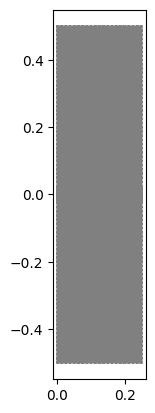

                      t = 0.0
                      Solving nonlinear variational problem.
                        Newton iteration 0: r (abs) = 1.981e+01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-10)
                        Newton iteration 1: r (abs) = 1.268e-03 (tol = 1.000e-10) r (rel) = 6.403e-05 (tol = 1.000e-10)
                        Newton iteration 2: r (abs) = 6.921e-08 (tol = 1.000e-10) r (rel) = 3.494e-09 (tol = 1.000e-10)
                        Newton iteration 3: r (abs) = 4.354e-13 (tol = 1.000e-10) r (rel) = 2.198e-14 (tol = 1.000e-10)
                        Newton solver finished in 3 iterations and 3 linear solver iterations.


KeyboardInterrupt: 

In [474]:
mesh = refine_mesh(mesh_corse, initial_conditions, 0.01)
df.plot(mesh)
plt.show()
function_space = get_space(mesh)
w0 = df.Function(function_space)
w0.assign(df.interpolate(initial_conditions, function_space))

while t < t_end:
    df.info(f"t = {t}")
    w = df.Function(function_space)
    pde_form = get_form(mesh, w, w0, function_space)
    solver = get_newton_solver(pde_form, w, get_bcs(function_space), ffc_options)
    solver.solve()
    w0.assign(w)
    t += dt
    # write the time-step into the file
    for func, name, xdmf in zip(w.split(True), ['v', 'p', 'l'], files):
        func.rename(name, name)
        xdmf.write(func, t)
    # creating the new mesh and reprojectiong the solutin 
    mesh_new = refine_mesh(mesh_corse, w, 0.01)
    v, p, l = w0.split(True)
    v = reproject(v, mesh, mesh_new)
    l = reproject(l, mesh, mesh_new)
    p = reproject(p, mesh, mesh_new)
    function_space = get_space(mesh_new)
    w0 = df.Function(function_space)
    df.assign(w0, [v, p, l])
    mesh = mesh_new